In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
import joblib
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_path = '../data/combined_keypoints.csv'
print(f"Loading data from {data_path}")
df = pd.read_csv(data_path)

print("First few rows of the dataset:")
print(df.head())

X = df.drop(columns=['Class'])
y = df['Class']

le = LabelEncoder()
y = le.fit_transform(y)
print("Class labels encoded.")

Loading data from ../data/combined_keypoints.csv
First few rows of the dataset:
        Class    Nose_x    Nose_y  Nose_conf  LeftEye_x  LeftEye_y  \
0  Warrior_II  0.275027  0.441496   0.838373   0.257330   0.454769   
1  Warrior_II  0.361404  0.488448   0.632348   0.354708   0.496576   
2  Warrior_II  0.226947  0.543324   0.787434   0.213398   0.533082   
3  Warrior_II  0.392478  0.374899   0.328839   0.381358   0.370187   
4  Warrior_II  0.223151  0.476531   0.887696   0.211527   0.493164   

   LeftEye_conf  RightEye_x  RightEye_y  RightEye_conf  ...  LeftKnee_conf  \
0      0.874609    0.258129    0.449623       0.896995  ...       0.941765   
1      0.715429    0.351345    0.491862       0.855811  ...       0.829439   
2      0.857410    0.214061    0.525327       0.864843  ...       0.923154   
3      0.546548    0.383478    0.369107       0.577419  ...       0.324949   
4      0.910345    0.209859    0.482766       0.860895  ...       0.828863   

   RightKnee_x  RightKnee_y  R

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data split into training and testing sets. Training size: {X_train.shape[0]}, Testing size: {X_test.shape[0]}")

Data split into training and testing sets. Training size: 10981, Testing size: 2746


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("Features standardized.")

pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print("PCA applied for dimensionality reduction.")


selector = SelectKBest(f_classif, k=30)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)
print("Feature selection applied.")

poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)
print("Polynomial features applied.")

svm_model = SVC(random_state=42)


param_space = {
    'C': Real(1, 20),
    'gamma': Real(1e-4, 1e-2, prior='log-uniform'),
    'kernel': Categorical(['poly', 'rbf']),
    'degree': Integer(2, 3),
    'coef0': Real(0, 10)
}

Features standardized.
PCA applied for dimensionality reduction.
Feature selection applied.
Polynomial features applied.


In [ ]:
print("Starting Bayesian optimization for SVM tuning.")
bayes_search = BayesSearchCV(
    svm_model, param_space, n_iter=30,
    scoring='accuracy', cv=StratifiedKFold(n_splits=5), verbose=1, random_state=42, n_jobs=-1)
bayes_search.fit(X_train, y_train)
print("Bayesian optimization completed.")

Starting Bayesian optimization for SVM tuning.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5

In [ ]:
best_svm_model = bayes_search.best_estimator_
print(f"Best SVM parameters found: {bayes_search.best_params_}")
print(f"Best SVM cross-validation score: {bayes_search.best_score_:.4f}")

Best SVM parameters found: OrderedDict([('C', 12.850190581090907), ('coef0', 7.0899244753711885), ('degree', 3), ('gamma', 0.000454343676047944), ('kernel', 'rbf')])
Best SVM cross-validation score: 0.7319


In [ ]:
print("Training the best SVM model with the best parameters.")
best_svm_model.fit(X_train, y_train)

Training the best SVM model with the best parameters.


SVC(C=12.850190581090907, coef0=7.0899244753711885, gamma=0.000454343676047944,
    random_state=42)

In [ ]:
print("Evaluating the best SVM model.")
y_pred_svm = best_svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
print(f"Best SVM Model Accuracy: {accuracy_svm:.4f}")
print(f"Best SVM Model Precision: {precision_svm:.4f}")
print(f"Best SVM Model Recall: {recall_svm:.4f}")
print(f"Best SVM Model F1 Score: {f1_svm:.4f}")

Evaluating the best SVM model.
Best SVM Model Accuracy: 0.7247
Best SVM Model Precision: 0.7328
Best SVM Model Recall: 0.7247
Best SVM Model F1 Score: 0.7242


In [ ]:
print("Best SVM Model Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

Best SVM Model Classification Report:
                                precision    recall  f1-score   support

       Bharadvaja's_Twist_pose       0.70      0.70      0.70        23
                          Boat       0.89      0.89      0.89        47
                   Bound_Angle       0.69      0.73      0.71        37
           Bow_or_Dhanurasana_       0.84      0.87      0.85        30
                        Bridge       0.96      0.89      0.92        27
                         Camel       0.89      0.86      0.87        36
                       Cat_Cow       0.88      0.91      0.90        47
                         Chair       0.66      0.73      0.69        37
                         Child       0.71      0.91      0.80        35
                         Cobra       0.81      0.88      0.85        94
                      Cockerel       0.43      0.60      0.50        20
                        Corpse       0.54      0.65      0.59        31
                      Cow

Generating Best SVM Model confusion matrix.


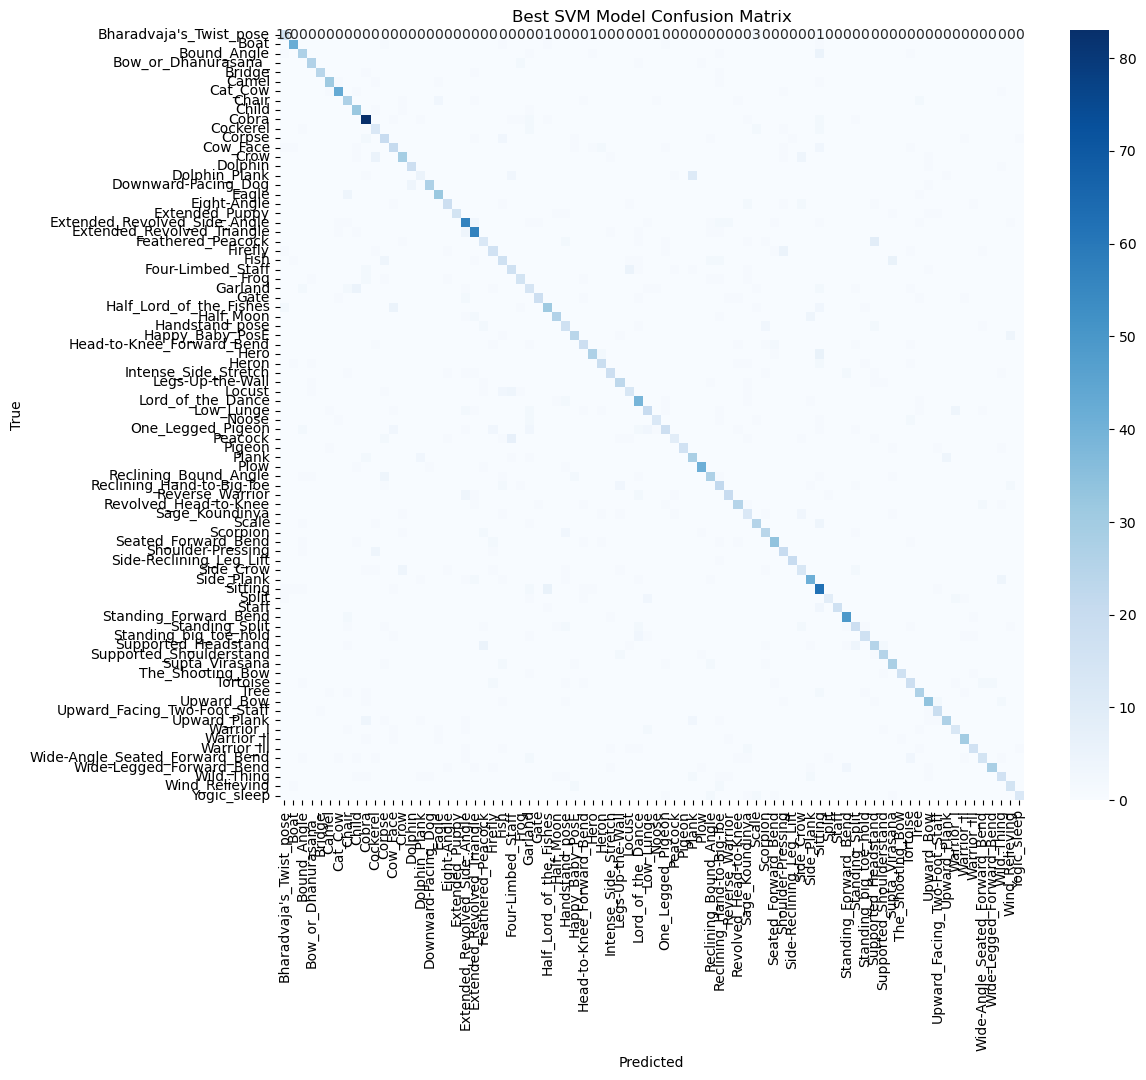

Best SVM Model Confusion matrix displayed.


In [ ]:
print("Generating Best SVM Model confusion matrix.")
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Best SVM Model Confusion Matrix')
plt.show()
print("Best SVM Model Confusion matrix displayed.")

In [ ]:
best_svm_model_path = 'best_svm_model.pkl'
joblib.dump(best_svm_model, best_svm_model_path)
print(f"Trained best SVM model saved to {best_svm_model_path}")